In [8]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt

df = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])

noto_hanto = {'coordinates':(136.686000, 37.220667), 'time':'2007-03-25 00:41:57.909996', 'tz':'UTC', 'magnitude':6.9}
western_tottori = {'coordinates':(133.349, 35.274167), 'time':'2000-10-06 04:30:17.940011', 'tz':'UTC', 'magnitude':6.7}
sugura_bay = {'coordinates':(138.499333, 34.786167), 'time':'2009-08-10 20:07:05.740017', 'tz':'UTC', 'magnitude':6.5}
iwaki = {'coordinates':(140.672667, 36.945667), 'time':'2011-04-11 08:16:12.020008', 'tz':'UTC', 'magnitude':6.6}
iwate_miyage = {'coordinates':(140.880667, 39.029833), 'time':'2008-06-13 23:43:45.359992', 'tz':'UTC', 'magnitude':6.8}
kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00', 'tz':'UTC', 'magnitude':7.0}
tohoku = {'coordinates':(142.861000, 38.103500), 'time':'2011-03-11 05:46:18.119983', 'tz':'UTC', 'magnitude':9.0}

def plot_earthquake_on_basemap(eq, m, ax, **kwargs):
    x, y = m(eq['coordinates'][0], eq['coordinates'][1])
    ax.scatter(x, y, s=0.75*np.exp(eq['magnitude']), **kwargs)
    ax.annotate('{year} M{mag}'.format(year=np.datetime64(eq['time']).astype('datetime64[Y]').astype(str)
                                              , mag=str(eq['magnitude']))
                , xy=(x, y), xytext=(x, y+0.5), fontsize=15, color='red', fontweight='bold')
    
eq = kumamoto
foreshock_time = eq['time']

df_regional = polygon_selection.get_node_data(data=df, node=eq['coordinates'], radius=75, m=1)
df_regional = df_regional.loc[df_regional.index < foreshock_time]
df_regional = df_regional[df_regional.mag >= 0.5]
df_regional = df_regional[df_regional.depth <= 25]

radii = np.arange(1, 51, 1)
timii = pd.date_range(start='01-01-1990 00:00:00', end=foreshock_time, freq='6M')
parameters = [x for x in product(radii, timii)]

n_iterations = 100

bdf = stats.calculate_b_value_parameter_sweep(dataframe=df_regional
                                              ,location=eq['coordinates']
                                              ,n_iterations=n_iterations
                                              ,parameters=parameters)

/home/max/pymap3/utilities/stats.py:45: RuntimeWarning: invalid value encountered in true_divide
  b_stddev = square_every_value((magnitudes - average).sum()) / (length * (length - 1))


In [10]:
rows = []

for r, t in parameters:
    df_c = polygon_selection.get_node_data(node=eq['coordinates'], data=df_regional, radius=r, m=1)
    df_c = df_c.loc[df_c.index >= t]
    
    a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_c.mag)
    row = np.array((r,) + (t,) + (a, b, bstd, n, mc))
    rows.append(row)
true_bdf = pd.DataFrame(rows, columns=['radius', 'start_time', 'a', 'b', 'bstd', 'n', 'mc'])

/home/max/pymap3/utilities/stats.py:45: RuntimeWarning: invalid value encountered in true_divide
  b_stddev = square_every_value((magnitudes - average).sum()) / (length * (length - 1))


# EARTHQUAKE_NAME

summary of earthquake

# EARTHQUAKE_NAME seismicity map

The regional seismicity is shown. The color indicates the depth of each earhtquake and the size indicates the magnitude.

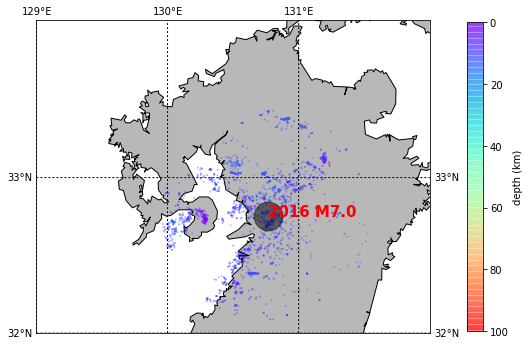

In [11]:
m, fig, ax = plotting.plot_seismicity_map(dataframe=df_regional[df_regional.mag>2])
plot_earthquake_on_basemap(eq, m, ax, color='black', alpha=0.5)

# EARTHQUAKE_NAME cumulative EQ count

The cumulative earthquake count is shown for the catalog above M0.5 between 1990 and immediately before the foreshock/mainshock.

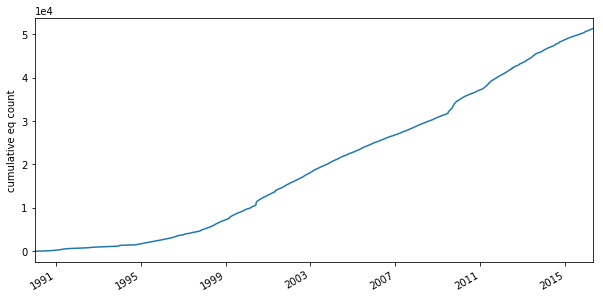

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
fig, ax = plotting.plot_seismicity_rate(dataframe=df_regional[df_regional.mag>=0.5], fig=fig, ax=ax)

# EARTHQUAKE_NAME hypocenter parameter search

The vertical axis indicates the selection radius (1-50km), the horizontal axis indicates the start time of the catalog (1990 to immediately before the foreshock and/or mainshock). The color indicates the b-value on the range of 0.6 to 0.9. The b-value is calculated using the maximum likelihood method and the catalog is cut by the magnitude of completeness using the maximum curvature method. The contours indicate the bootstrapped standard deviation from 0.0 to 0.1.

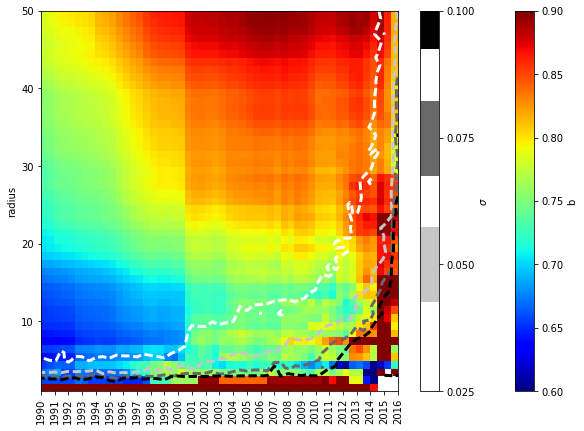

In [13]:
# radii = np.arange(1, 51, 1)
# foreshock_time = eq['time']

# timii = pd.date_range(start='01-01-1990 00:00:00', end=foreshock_time, freq='6M', tz='GMT')
# parameters = [x for x in product(radii, timii)]
# df_regional = df_regional.loc[df_regional.index < foreshock_time]
# # df_regional = df_regional[df_regional.mag >= 0.5]
# # df_regional = df_regional[df_regional.depth <= 25]
# n_iterations = 100

# bdf = stats.calculate_b_value_parameter_sweep(dataframe=df_regional
#                                               ,location=eq['coordinates']
#                                               ,n_iterations=n_iterations
#                                               ,parameters=parameters)



# df_calc = df_regional.copy()

# rows = []

# for r, t in parameters:
#     df_c = polygon_selection.get_node_data(node=eq['coordinates'], data=df_calc, radius=r, m=1)
#     df_c = df_c.loc[df_c.index >= t]
    
#     a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_c.mag)
#     row = np.array((r,) + (t,) + (a, b, bstd, n, mc))
#     rows.append(row)
# true_bdf = pd.DataFrame(rows, columns=['radius', 'start_time', 'a', 'b', 'bstd', 'n', 'mc'])



# import scipy.ndimage

fig, ax = plt.subplots(figsize=(10,7))

fig, ax = plotting.plot_radius_time_sweep(dataframe=true_bdf, vertical_axis='radius'
                                 , value='b',vmin=0.6, vmax=0.9, cmap='jet', fig=fig, ax=ax)

zi = bdf.pivot(index='start_time', columns='radius', values='b_std')
xi_label = [np.datetime64(z, 'Y') for z in zi.index]
xi = np.arange(len(xi_label))
yi = zi.columns
xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi).transpose()

# levels = [10, 50, 250, 1000, 5000]
levels = [0.025, 0.05, 0.075, 0.1]
cs = ax.contour(xi,yi,zi, levels, cmap='Greys', linewidths=3, linestyles='--')#, locator=ticker.LogLocator())
# cs = ax.contourf(xi,yi,zi, levels, cmap='Greys', linewidths=3, linestyles='--', alpha=0.0)#, locator=ticker.LogLocator())
# cs = ax.contour(xi,yi,zi, colors='black')#, locator=ticker.LogLocator())

# cs.levels = ['$\pm 0.2 \sigma$', '>50 EQs','>250 EQs', '>1000 EQs', '>5000 EQs']

# ax.clabel(cs, cs.levels, inline=True)
# ax.set_ylim(0,50)

cb = fig.colorbar(cs, label='$\sigma$')
for line in cb.lines:
    line.set_linewidth(75)
# fig.savefig('b_std_kumamoto_parameter.png', dpi=300, bbox_inches='tight', transparency=True)

# EARTHQUAKE_NAME b-value over time

The b-value is plotted on the vertical axis with the range of selection radii (1-50km) is plotted on the horizontal accident. The color indicates the start time of the catalog (in epoch ms), and the bars indicate the bootstrapped standard error.

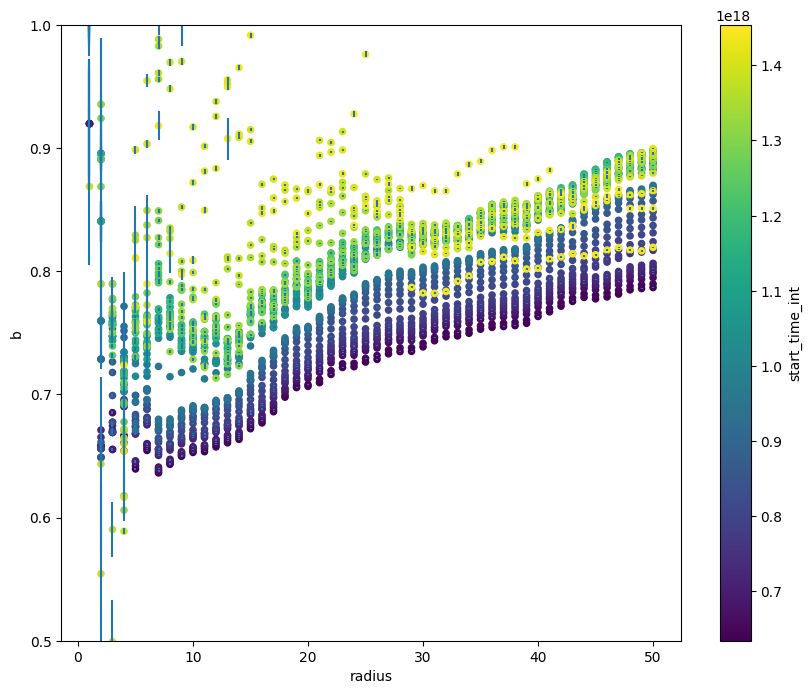

In [14]:
plt.style.use('default')


fig, ax = plt.subplots(figsize=(10,8))

true_bdf['start_time_int'] = pd.to_datetime(true_bdf.start_time).astype('int')
ax = true_bdf.plot(kind='scatter', x='radius', y='b', c='start_time_int', cmap='viridis', ax=ax
                  ,yerr=bdf.b_std.values/np.sqrt(bdf.shape[0]))
ylim = ax.set_ylim(0.5, 1)